#Movie Recommendation System

##SEL 1: IMPORT LIBRARIES DAN SETUP

Tujuan: Mengimpor semua library yang diperlukan untuk analisis data,
        preprocessing, modeling, dan evaluasi sistem rekomendasi

Fungsi:
- pandas untuk manipulasi data
- numpy untuk operasi numerik
- sklearn untuk TF-IDF, cosine similarity, dan metrics
- matplotlib/seaborn untuk visualisasi
- warnings untuk menghilangkan warning yang tidak perlu


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import re
import ast
from collections import Counter

# Konfigurasi untuk visualisasi
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("✅ Libraries berhasil diimport!")

✅ Libraries berhasil diimport!


##SEL 2: SETUP API KAGGLE
Fungsi: Mengatur autentikasi Kaggle API untuk mendownload dataset MovieLens.

In [2]:
# Upload file kaggle.json ke Colab
from google.colab import files
print("Silakan upload file kaggle.json Anda:")
uploaded = files.upload()

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle API berhasil dikonfigurasi!")

Silakan upload file kaggle.json Anda:


Saving kaggle.json to kaggle.json
✅ Kaggle API berhasil dikonfigurasi!


##SEL 3: LOAD DATASET

Tujuan:
Memuat dataset film dari file CSV yang berasal dari Kaggle

Dataset:
The Movies Dataset - https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset


In [3]:
!kaggle datasets download -d rounakbanik/the-movies-dataset
!unzip the-movies-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset
License(s): CC0-1.0
 94% 213M/228M [00:00<00:00, 322MB/s]
100% 228M/228M [00:00<00:00, 366MB/s]
Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


##SEL 4: EXPLORATORY DATA ANALYSIS (EDA) - OVERVIEW DATA
Tujuan: Melakukan analisis eksplorasi data awal

Fungsi:
- Melihat 5 baris pertama data
- Mengecek informasi dataset (tipe data, missing values)
- Memahami karakteristik data film

In [4]:
movies_df = pd.read_csv('movies_metadata.csv', low_memory=False)

# Tampilkan 5 baris pertama
print("\n🔍 5 Baris Pertama Dataset:")
display(movies_df.head())

# Informasi dataset
print("\n📊 Informasi Dataset:")
print(movies_df.info())

# Statistik deskriptif untuk kolom numerik
print("\n📈 Statistik Deskriptif Kolom Numerik:")
display(movies_df.describe())


🔍 5 Baris Pertama Dataset:


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0



📊 Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non

,revenue,runtime,vote_average,vote_count
count,4.546000e+04,45203.000000,45460.000000,45460.000000
mean,1.120935e+07,94.128199,5.618207,109.897338
std,6.433225e+07,38.407810,1.924216,491.310374
min,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,107.000000,6.800000,34.000000
max,2.787965e+09,1256.000000,10.000000,14075.000000


## SEL 5: DATA UNDERSTANDING - ANALISIS MISSING VALUES
Tujuan: Menganalisis missing values dalam dataset

Fungsi:
- Menghitung jumlah dan persentase missing values per kolom
- Memvisualisasikan missing values
- Memahami kelengkapan data untuk setiap fitur

In [5]:
# Hitung missing values
missing_values = movies_df.isnull().sum()
missing_percentage = (missing_values / len(movies_df)) * 100

# Buat DataFrame untuk missing values
missing_df = pd.DataFrame({
    'Column': missing_values.index,
    'Missing_Count': missing_values.values,
    'Missing_Percentage': missing_percentage.values
}).sort_values('Missing_Percentage', ascending=False)

print("📋 Missing Values per Kolom:")
display(missing_df[missing_df['Missing_Count'] > 0])

📋 Missing Values per Kolom:


,Column,Missing_Count,Missing_Percentage
1,belongs_to_collection,40972,90.115691
4,homepage,37684,82.883913
19,tagline,25054,55.104914
9,overview,954,2.098271
11,poster_path,386,0.848986
16,runtime,263,0.578454
18,status,87,0.191352
14,release_date,87,0.191352
6,imdb_id,17,0.037391
7,original_language,11,0.024194


## SEL 6: DATA UNDERSTANDING - ANALISIS DISTRIBUSI GENRE DAN TAHUN
Tujuan: Menganalisis distribusi genre dan tahun rilis film

Fungsi:
- Memahami genre yang paling populer
- Melihat tren film berdasarkan tahun rilis
- Memberikan insight tentang karakteristik dataset


📈 Statistik Deskriptif Kolom Popularitas Film:


,popularity
count,45460.000000
mean,2.921478
std,6.005414
min,0.000000
25%,0.385948
50%,1.127685
75%,3.678902
max,547.488298


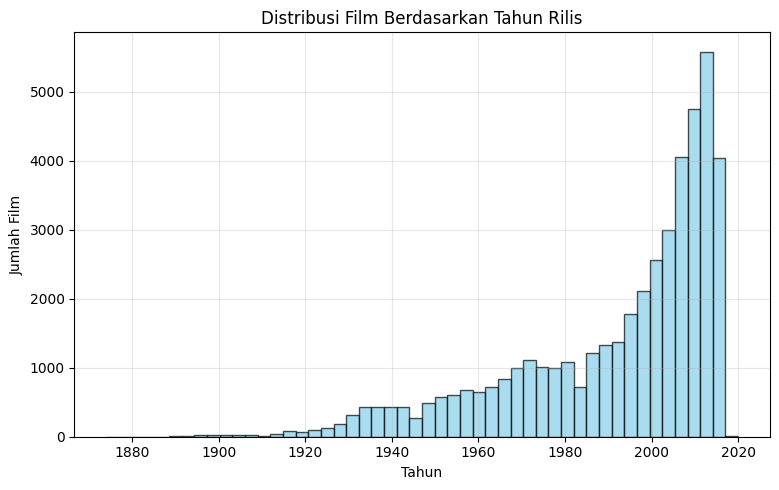


🔝 Top 10 Tahun dengan Film Terbanyak:
release_year
2014.0    1974
2015.0    1905
2013.0    1889
2012.0    1722
2011.0    1667
2016.0    1604
2009.0    1586
2010.0    1501
2008.0    1473
2007.0    1320
Name: count, dtype: int64


In [6]:
# Konversi release_date ke datetime dan ekstrak tahun
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'], errors='coerce')
movies_df['release_year'] = movies_df['release_date'].dt.year

# Analisis distribusi tahun rilis
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
movies_df['release_year'].hist(bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribusi Film Berdasarkan Tahun Rilis')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Film')
plt.grid(True, alpha=0.3)

# Hapus plot distribusi popularitas dan tampilkan statistik deskriptif dalam teks
# Konversi kolom popularity ke numerik, tangani error
movies_df['popularity'] = pd.to_numeric(movies_df['popularity'], errors='coerce')

print("\n📈 Statistik Deskriptif Kolom Popularitas Film:")
display(movies_df['popularity'].describe())

# Hapus subplot kedua untuk popularity plot
# plt.subplot(1, 2, 2)
# movies_df['popularity'].hist(bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
# plt.title('Distribusi Popularitas Film')
# plt.xlabel('Popularity Score')
# plt.ylabel('Jumlah Film')
# plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Top 10 tahun dengan film terbanyak
print("\n🔝 Top 10 Tahun dengan Film Terbanyak:")
top_years = movies_df['release_year'].value_counts().head(10)
print(top_years)

## SEL 7: DATA PREPARATION - CLEANING DAN FILTERING

Tujuan: Membersihkan dan memfilter data untuk sistem rekomendasi

Fungsi:
- Menghapus baris dengan missing values pada kolom penting
- Memfilter film dengan data lengkap
- Mempersiapkan data untuk content-based filtering

In [7]:
# Simpan ukuran dataset awal
original_size = len(movies_df)
print(f"📊 Ukuran dataset awal: {original_size:,} film")

# Kolom yang penting untuk content-based filtering
important_columns = ['title', 'overview', 'genres', 'release_date', 'vote_average', 'popularity']

# Hapus baris dengan missing values pada kolom penting
movies_clean = movies_df.dropna(subset=['title', 'overview'])

print(f"📊 Ukuran dataset setelah cleaning: {len(movies_clean):,} film")
print(f"📉 Data yang dihapus: {original_size - len(movies_clean):,} film ({((original_size - len(movies_clean))/original_size)*100:.1f}%)")

# Filter film dengan tahun rilis yang valid (1900-2024)
movies_clean = movies_clean[(movies_clean['release_year'] >= 1900) & (movies_clean['release_year'] <= 2024)]
print(f"📊 Ukuran dataset setelah filter tahun: {len(movies_clean):,} film")

# Reset index
movies_clean = movies_clean.reset_index(drop=True)

print("✅ Data cleaning selesai!")

📊 Ukuran dataset awal: 45,466 film
📊 Ukuran dataset setelah cleaning: 44,506 film
📉 Data yang dihapus: 960 film (2.1%)
📊 Ukuran dataset setelah filter tahun: 44,355 film
✅ Data cleaning selesai!


## SEL 8: DATA PREPARATION - PREPROCESSING GENRES

Tujuan: Memproses kolom genres dari format JSON ke format yang bisa digunakan

Fungsi:
- Mengkonversi string JSON genres menjadi list
- Mengekstrak nama genre saja
- Membuat kolom genres_str untuk content-based filtering

🎭 PREPROCESSING GENRES
🔝 Top 10 Genre Paling Populer:
   Drama: 20,010 film
   Comedy: 12,795 film
   Thriller: 7,581 film
   Romance: 6,670 film
   Action: 6,559 film
   Horror: 4,651 film
   Crime: 4,268 film
   Documentary: 3,843 film
   Adventure: 3,468 film
   Science Fiction: 3,020 film


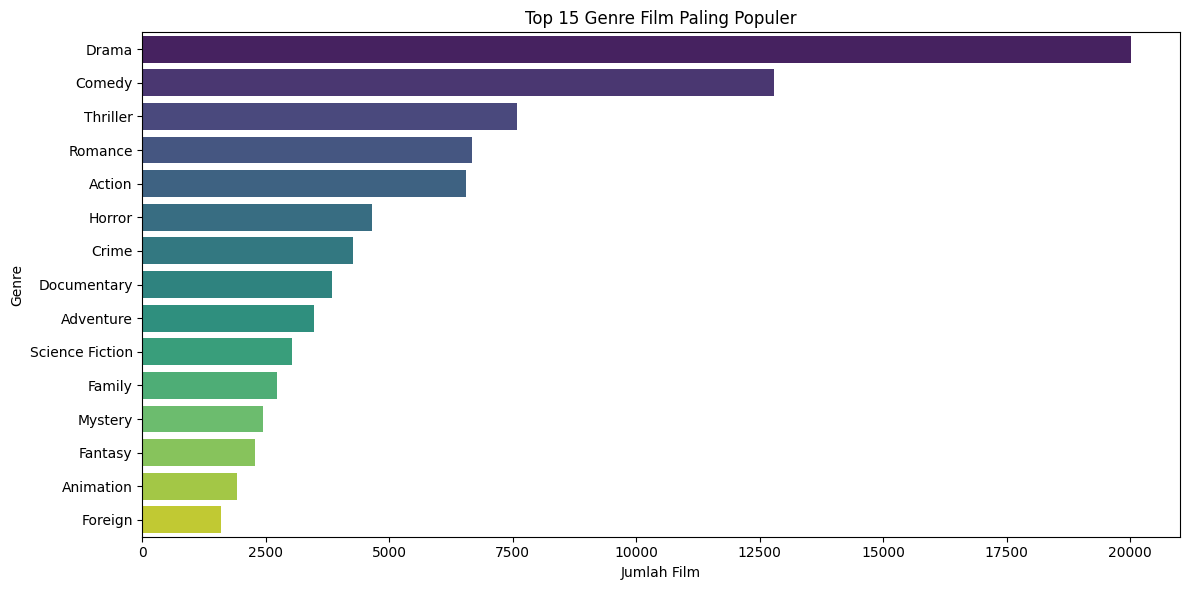

✅ Preprocessing genres selesai!


In [8]:
def extract_genres(genres_str):
    """
    Fungsi untuk mengekstrak nama genre dari string JSON
    Input: String JSON genres
    Output: List nama genre
    """
    try:
        genres_list = ast.literal_eval(genres_str)
        return [genre['name'] for genre in genres_list]
    except:
        return []

print("🎭 PREPROCESSING GENRES")
print("="*30)

# Ekstrak genres
movies_clean['genres_list'] = movies_clean['genres'].apply(extract_genres)

# Buat string genres untuk TF-IDF
movies_clean['genres_str'] = movies_clean['genres_list'].apply(lambda x: ' '.join(x))

# Analisis genre paling populer
all_genres = []
for genres in movies_clean['genres_list']:
    all_genres.extend(genres)

genre_counts = Counter(all_genres)
print("🔝 Top 10 Genre Paling Populer:")
for genre, count in genre_counts.most_common(10):
    print(f"   {genre}: {count:,} film")

# Visualisasi top genres
plt.figure(figsize=(12, 6))
top_genres_df = pd.DataFrame(genre_counts.most_common(15), columns=['Genre', 'Count'])
sns.barplot(data=top_genres_df, x='Count', y='Genre', palette='viridis')
plt.title('Top 15 Genre Film Paling Populer')
plt.xlabel('Jumlah Film')
plt.tight_layout()
plt.show()

print("✅ Preprocessing genres selesai!")

## SEL 9: DATA PREPARATION - TEXT PREPROCESSING

Tujuan: Memproses teks overview untuk content-based filtering

Fungsi:
- Membersihkan teks dari karakter khusus
- Mengonversi ke lowercase
- Mempersiapkan teks untuk TF-IDF vectorization

In [9]:
def clean_text(text):
    """
    Fungsi untuk membersihkan teks
    Input: Raw text
    Output: Clean text
    """
    if pd.isna(text):
        return ""
    # Hapus karakter khusus dan angka
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    # Konversi ke lowercase
    text = text.lower()
    # Hapus extra whitespace
    text = ' '.join(text.split())
    return text

print("📝 TEXT PREPROCESSING")
print("="*25)

# Clean overview text
movies_clean['overview_clean'] = movies_clean['overview'].apply(clean_text)

# Gabungkan genre dan overview untuk content features
movies_clean['content_features'] = movies_clean['genres_str'] + ' ' + movies_clean['overview_clean']

# Statistik teks
avg_overview_length = movies_clean['overview_clean'].str.len().mean()
print(f"📊 Rata-rata panjang overview: {avg_overview_length:.0f} karakter")

# Contoh hasil preprocessing
print("\n💡 Contoh Text Preprocessing:")
sample_idx = 0
print(f"Original: {movies_clean.iloc[sample_idx]['overview'][:100]}...")
print(f"Cleaned:  {movies_clean.iloc[sample_idx]['overview_clean'][:100]}...")

print("✅ Text preprocessing selesai!")


📝 TEXT PREPROCESSING
📊 Rata-rata panjang overview: 313 karakter

💡 Contoh Text Preprocessing:
Original: Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto ...
Cleaned:  led by woody andys toys live happily in his room until andys birthday brings buzz lightyear onto the...
✅ Text preprocessing selesai!


## SEL 10: FEATURE ENGINEERING - TF-IDF VECTORIZATION
Tujuan: Mengkonversi teks menjadi vektor numerik menggunakan TF-IDF

Fungsi:
- Membuat TF-IDF matrix dari content features
- Menggunakan parameter optimal untuk movie recommendation
- Mempersiapkan data untuk similarity calculation

In [10]:
# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,      # Batasi fitur untuk efisiensi
    stop_words='english',   # Hapus stop words
    ngram_range=(1, 2),     # Unigram dan bigram
    min_df=2,               # Minimum document frequency
    max_df=0.8              # Maximum document frequency
)

# Fit dan transform content features
print("⚙️ Melakukan TF-IDF vectorization...")
tfidf_matrix = tfidf.fit_transform(movies_clean['content_features'])

print(f"✅ TF-IDF Matrix Shape: {tfidf_matrix.shape}")
print(f"📊 Jumlah film: {tfidf_matrix.shape[0]:,}")
print(f"📊 Jumlah fitur: {tfidf_matrix.shape[1]:,}")

# Lihat beberapa fitur teratas
feature_names = tfidf.get_feature_names_out()
print(f"\n💡 Contoh fitur TF-IDF: {list(feature_names[:10])}")

print("✅ Feature engineering selesai!")

⚙️ Melakukan TF-IDF vectorization...
✅ TF-IDF Matrix Shape: (44355, 5000)
📊 Jumlah film: 44,355
📊 Jumlah fitur: 5,000

💡 Contoh fitur TF-IDF: ['aaron', 'abandoned', 'abandons', 'abducted', 'abilities', 'ability', 'able', 'aboard', 'abroad', 'absence']
✅ Feature engineering selesai!


## SEL 11: MODELING - CONTENT BASED FILTERING SYSTEM
Tujuan: Membuat sistem rekomendasi content-based filtering

Fungsi:
- Menghitung cosine similarity antar film
- Membuat fungsi rekomendasi berdasarkan kesamaan konten
- Implementasi algoritma content-based filtering

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Buat mapping dari judul film ke index
# Pastikan movies_clean dan tfidf_matrix sudah tersedia dari sel sebelumnya
if 'movies_clean' not in locals() or movies_clean.empty:
    print("Error: movies_clean DataFrame not found or is empty. Please run preceding cells.")
    # You might want to exit or handle this case appropriately
elif 'tfidf_matrix' not in locals():
     print("Error: tfidf_matrix not found. Please run SEL 10 first.")
     # You might want to exit or handle this case appropriately
else:
    title_to_index = pd.Series(movies_clean.index, index=movies_clean['title']).drop_duplicates()
    print("✅ Title to index mapping created!")


def get_content_recommendations_ondemand(title, tfidf_matrix=None, df=None, top_n=10):
    """
    Fungsi untuk mendapatkan rekomendasi film berdasarkan content-based filtering
    dengan perhitungan similarity on-demand.

    Parameters:
    title (str): Judul film yang dijadikan referensi
    tfidf_matrix (sparse matrix): TF-IDF matrix dari dataset film
    df (DataFrame): Dataset film (movies_clean)
    top_n (int): Jumlah rekomendasi yang diinginkan

    Returns:
    DataFrame: Film-film yang direkomendasikan
    """
    if tfidf_matrix is None or df is None:
        print("Error: tfidf_matrix or DataFrame not provided.")
        return pd.DataFrame()

    try:
        # Dapatkan index film
        if title not in df['title'].values:
             print(f"❌ Film '{title}' tidak ditemukan dalam dataset")
             return pd.DataFrame()

        idx = df[df['title'] == title].index[0]

        # Dapatkan vektor TF-IDF untuk film referensi
        ref_vector = tfidf_matrix[idx]

        # Hitung similarity scores antara film referensi dan semua film lain
        # Menghasilkan array 1D dari similarity scores
        sim_scores = cosine_similarity(ref_vector, tfidf_matrix).flatten()

        # Buat list of (index, score) tuples
        sim_scores = list(enumerate(sim_scores))

        # Sort berdasarkan similarity score
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Ambil top N (exclude film itu sendiri)
        # Pastikan ada cukup skor setelah mengecualikan film referensi
        if len(sim_scores) > 1:
            sim_scores = sim_scores[1:top_n+1]
        else:
            return pd.DataFrame() # Tidak ada film lain untuk direkomendasikan

        # Dapatkan indices film
        movie_indices = [i[0] for i in sim_scores]

        # Return film yang direkomendasikan
        recommendations = df.iloc[movie_indices][['title', 'genres_str', 'vote_average', 'popularity', 'release_year']].copy()
        recommendations['similarity_score'] = [score[1] for score in sim_scores]

        return recommendations

    except KeyError:
        # Ini seharusnya ditangani oleh pengecekan 'if title not in df['title'].values' di atas
        # Tapi tetap disertakan sebagai fallback
        print(f"❌ Film '{title}' tidak ditemukan dalam dataset")
        return pd.DataFrame()
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()


print("✅ Content-based filtering system (on-demand similarity) berhasil dibuat!")

✅ Title to index mapping created!
✅ Content-based filtering system (on-demand similarity) berhasil dibuat!


## SEL 12: TESTING SISTEM REKOMENDASI
Tujuan: Menguji sistem rekomendasi dengan beberapa contoh film

Fungsi:
- Menguji fungsi rekomendasi dengan film populer
- Menampilkan hasil rekomendasi
- Memvalidasi kualitas rekomendasi

In [13]:
# Pilih beberapa film populer untuk testing
test_movies = ['Toy Story', 'The Dark Knight', 'Forrest Gump', 'The Matrix']

for movie_title in test_movies:
    # Use the correct function name and pass required data
    if movie_title in movies_clean['title'].values: # Check if movie exists in the cleaned data
        print(f"\n🎬 REKOMENDASI UNTUK: {movie_title}")
        print("="*50)

        # Dapatkan info film referensi dari movies_clean
        ref_movie = movies_clean[movies_clean['title'] == movie_title].iloc[0]
        print(f"📝 Genre: {ref_movie['genres_str']}")
        print(f"⭐ Rating: {ref_movie['vote_average']}")
        print(f"📅 Tahun: {ref_movie['release_year']:.0f}") # Format year as integer

        # Dapatkan rekomendasi menggunakan fungsi on-demand
        recommendations = get_content_recommendations_ondemand(
            movie_title,
            tfidf_matrix=tfidf_matrix, # Pass tfidf_matrix
            df=movies_clean # Pass movies_clean df
        )

        if not recommendations.empty:
            print(f"\n🔝 Top {len(recommendations)} Rekomendasi:")
            # Iterate through the first 5 recommendations
            for idx, (_, row) in enumerate(recommendations.head().iterrows(), 1):
                print(f"{idx}. {row['title']} ({row['release_year']:.0f})")
                print(f"   Genre: {row['genres_str']}")
                print(f"   Rating: {row['vote_average']:.1f} | Similarity: {row['similarity_score']:.3f}")
                print()
        else:
            print("❌ Tidak dapat memberikan rekomendasi untuk film ini.")

    else:
        print(f"\n❌ Film '{movie_title}' tidak ditemukan dalam dataset yang sudah dibersihkan.")


🎬 REKOMENDASI UNTUK: Toy Story
📝 Genre: Animation Comedy Family
⭐ Rating: 7.7
📅 Tahun: 1995

🔝 Top 10 Rekomendasi:
1. Banana (2010)
   Genre: Animation Comedy Family
   Rating: 7.2 | Similarity: 0.255

2. Toy Story 2 (1999)
   Genre: Animation Comedy Family
   Rating: 7.3 | Similarity: 0.237

3. Hawaiian Vacation (2011)
   Genre: Animation Family
   Rating: 6.9 | Similarity: 0.231

4. Botsman i Popugay (1982)
   Genre: Animation Comedy Family
   Rating: 7.0 | Similarity: 0.229

5. Mr. Bug Goes to Town (1941)
   Genre: Animation Comedy Family
   Rating: 5.7 | Similarity: 0.223


🎬 REKOMENDASI UNTUK: The Dark Knight
📝 Genre: Drama Action Crime Thriller
⭐ Rating: 8.3
📅 Tahun: 2008

🔝 Top 10 Rekomendasi:
1. The Dark Knight Rises (2012)
   Genre: Action Crime Drama Thriller
   Rating: 7.6 | Similarity: 0.318

2. Batman Forever (1995)
   Genre: Action Crime Fantasy
   Rating: 5.2 | Similarity: 0.278

3. Batman: The Dark Knight Returns, Part 2 (2013)
   Genre: Action Animation
   Rating: 7.9

## SEL 13: EVALUASI SISTEM - PRECISION DAN DIVERSITY

Tujuan: Mengevaluasi kualitas sistem rekomendasi

Fungsi:
- Menghitung precision berdasarkan genre similarity
- Mengukur diversity rekomendasi
- Mengevaluasi coverage sistem

In [16]:
import numpy as np # Import numpy

def evaluate_genre_precision(reference_movie, recommendations):
    """
    Menghitung precision berdasarkan kesamaan genre
    """
    # Ensure genres_list exists and is a list
    ref_genres = set(reference_movie.get('genres_list', []))
    if not ref_genres:
        # If reference movie has no genres, precision is 0
        return 0.0

    relevant_count = 0
    # Ensure recommendations DataFrame is not empty
    if recommendations.empty:
        return 0.0

    for _, rec_movie in recommendations.iterrows():
        # Get the original index from movies_clean using the title
        rec_title = rec_movie['title']
        # Find the row in movies_clean that matches the title
        original_movie_row = movies_clean[movies_clean['title'] == rec_title].iloc[0]
        # Ensure genres_list exists and is a list
        rec_genres = set(original_movie_row.get('genres_list', []))

        if ref_genres.intersection(rec_genres):
            relevant_count += 1

    return relevant_count / len(recommendations)


def calculate_diversity(recommendations):
    """
    Menghitung diversity rekomendasi berdasarkan variasi genre
    """
    all_genres = []
    # Ensure recommendations DataFrame is not empty
    if recommendations.empty:
        return 0.0

    for _, movie in recommendations.iterrows():
        # Get the original index from movies_clean using the title
        movie_title = movie['title']
        # Find the row in movies_clean that matches the title
        original_movie_row = movies_clean[movies_clean['title'] == movie_title].iloc[0]
        # Ensure genres_list exists and is a list
        all_genres.extend(original_movie_row.get('genres_list', []))

    unique_genres = len(set(all_genres))
    total_genres = len(all_genres)

    return unique_genres / total_genres if total_genres > 0 else 0.0

print("📊 EVALUASI SISTEM REKOMENDASI")
print("="*40)

# Evaluasi dengan sample film
sample_movies = ['Toy Story', 'The Dark Knight', 'Forrest Gump']
precision_scores = []
diversity_scores = []

for movie_title in sample_movies:
    if movie_title in movies_clean['title'].values: # Check if movie exists
        # Get reference movie
        ref_movie = movies_clean[movies_clean['title'] == movie_title].iloc[0]

        # Get recommendations using the on-demand function
        recommendations = get_content_recommendations_ondemand(
            movie_title,
            tfidf_matrix=tfidf_matrix,
            df=movies_clean,
            top_n=10 # Evaluate on top 10 recommendations
        )

        if not recommendations.empty:
            # Hitung precision
            precision = evaluate_genre_precision(ref_movie, recommendations)
            precision_scores.append(precision)

            # Hitung diversity
            diversity = calculate_diversity(recommendations)
            diversity_scores.append(diversity)

            print(f"\n🎬 {movie_title}:")
            print(f"   Genre Precision: {precision:.3f}")
            print(f"   Diversity Score: {diversity:.3f}")
        else:
            print(f"\n❌ Tidak dapat mengevaluasi untuk film '{movie_title}' (Tidak ada rekomendasi).")


# Overall metrics
if precision_scores and diversity_scores:
    avg_precision = np.mean(precision_scores)
    avg_diversity = np.mean(diversity_scores)

    print(f"\n📈 OVERALL PERFORMANCE:")
    print(f"   Average Genre Precision: {avg_precision:.3f}")
    print(f"   Average Diversity Score: {avg_diversity:.3f}")

    # Coverage analysis (simple count of movies in the cleaned dataset)
    total_movies = len(movies_clean)
    print(f"   Dataset Coverage: {total_movies:,} film")
elif not sample_movies:
    print("Tidak ada film sampel untuk dievaluasi.")
else:
     print("Tidak ada rekomendasi yang dihasilkan untuk film sampel yang dipilih. Evaluasi tidak dapat dilakukan.")


print("✅ Evaluasi sistem selesai!")

📊 EVALUASI SISTEM REKOMENDASI

🎬 Toy Story:
   Genre Precision: 1.000
   Diversity Score: 0.148

🎬 The Dark Knight:
   Genre Precision: 0.900
   Diversity Score: 0.357

🎬 Forrest Gump:
   Genre Precision: 0.900
   Diversity Score: 0.273

📈 OVERALL PERFORMANCE:
   Average Genre Precision: 0.933
   Average Diversity Score: 0.259
   Dataset Coverage: 44,355 film
✅ Evaluasi sistem selesai!


## SEL 14: VISUALISASI HASIL EVALUASI
Tujuan: Memvisualisasikan hasil evaluasi sistem rekomendasi

Fungsi:
- Membuat grafik performance metrics
- Menampilkan distribusi similarity scores
- Visualisasi kualitas rekomendasi

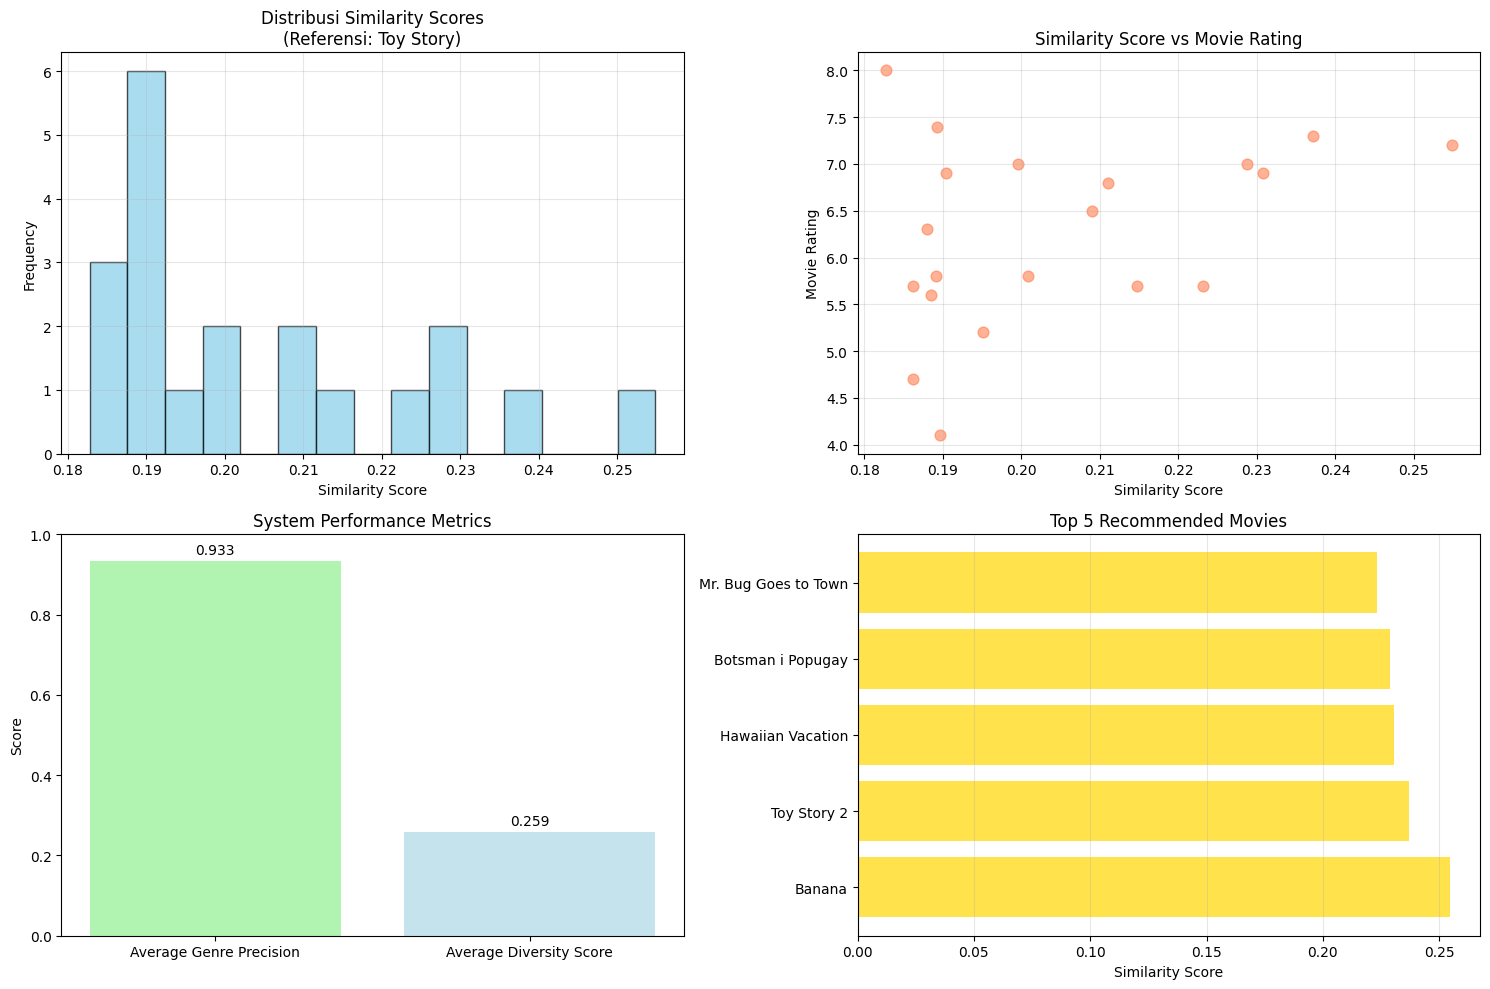

✅ Visualisasi selesai!


In [18]:
# SEL 14: VISUALISASI HASIL EVALUASI

# Ambil sample recommendations untuk analisis
sample_movie = 'Toy Story'
# Check if sample_movie exists in movies_clean before proceeding
if sample_movie in movies_clean['title'].values:
    recommendations = get_content_recommendations_ondemand(
        sample_movie,
        tfidf_matrix=tfidf_matrix,
        df=movies_clean,
        top_n=20
    )

    if not recommendations.empty:
        plt.figure(figsize=(15, 10))

        # Plot 1: Distribusi Similarity Scores
        plt.subplot(2, 2, 1)
        plt.hist(recommendations['similarity_score'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title(f'Distribusi Similarity Scores\n(Referensi: {sample_movie})')
        plt.xlabel('Similarity Score')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)

        # Plot 2: Rating vs Similarity
        plt.subplot(2, 2, 2)
        plt.scatter(recommendations['similarity_score'], recommendations['vote_average'],
                    alpha=0.6, color='coral', s=60)
        plt.title('Similarity Score vs Movie Rating')
        plt.xlabel('Similarity Score')
        plt.ylabel('Movie Rating')
        plt.grid(True, alpha=0.3)

        # Plot 3: Performance Metrics
        plt.subplot(2, 2, 3)
        metrics = ['Average Genre Precision', 'Average Diversity Score']
        # Ensure avg_precision and avg_diversity are defined (from SEL 13)
        values = [avg_precision, avg_diversity] if 'avg_precision' in locals() and 'avg_diversity' in locals() else [0, 0] # Default to 0 if not defined

        bars = plt.bar(metrics, values, color=['lightgreen', 'lightblue'], alpha=0.7)
        plt.title('System Performance Metrics')
        plt.ylabel('Score')
        plt.ylim(0, 1)

        # Tambahkan nilai di atas bar
        for bar, value in zip(bars, values):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom')

        # Plot 4: Top Recommended Movies
        plt.subplot(2, 2, 4)
        top_5 = recommendations.head(5)
        y_pos = np.arange(len(top_5))

        plt.barh(y_pos, top_5['similarity_score'], color='gold', alpha=0.7)
        plt.yticks(y_pos, [title[:20] + '...' if len(title) > 20 else title for title in top_5['title']])
        plt.xlabel('Similarity Score')
        plt.title('Top 5 Recommended Movies')
        plt.grid(True, alpha=0.3, axis='x')

        plt.tight_layout()
        plt.show()
    else:
        print(f"Tidak ada rekomendasi yang dihasilkan untuk film '{sample_movie}'. Tidak dapat membuat visualisasi.")
else:
    print(f"Film '{sample_movie}' tidak ditemukan dalam dataset yang sudah dibersihkan. Tidak dapat membuat visualisasi.")


print("✅ Visualisasi selesai!")

## SEL 15: FUNGSI REKOMENDASI INTERAKTIF
Tujuan: Membuat fungsi rekomendasi yang user-friendly

Fungsi:
- Interface yang mudah digunakan
- Pencarian film dengan partial matching
- Output yang informatif dan terstruktur

In [28]:
def search_movies(query, df=movies_clean, limit=5):
    """
    Mencari film berdasarkan query (partial matching)
    """
    matches = df[df['title'].str.contains(query, case=False, na=False)]
    return matches[['title', 'release_year', 'genres_str', 'vote_average']].head(limit)

def recommend_movies_interactive(movie_title, top_n=10):
    """
    Fungsi rekomendasi interaktif dengan output yang user-friendly
    """
    print(f"🔍 SISTEM REKOMENDASI FILM")
    print("="*50)

    # Cek apakah film ditemukan secara eksak
    matched = movies_clean[movies_clean['title'] == movie_title]
    if matched.empty:
        print(f"❌ Film '{movie_title}' tidak ditemukan secara eksak.")
        print("🔍 Mencari film dengan nama serupa...")

        similar_movies = search_movies(movie_title)
        if not similar_movies.empty:
            print("\n📋 Film yang mungkin Anda maksud:")
            for idx, (_, movie) in enumerate(similar_movies.iterrows(), 1):
                print(f"{idx}. {movie['title']} ({movie['release_year']:.0f})")
        else:
            print("❌ Tidak ada film yang cocok ditemukan.")
        return

    # Gunakan baris pertama hasil pencarian sebagai referensi
    ref_movie = matched.iloc[0]

    print(f"🎬 FILM REFERENSI: {movie_title}")
    print(f"📅 Tahun: {ref_movie['release_year']:.0f}")
    print(f"🎭 Genre: {ref_movie['genres_str']}")
    print(f"⭐ Rating: {ref_movie['vote_average']:.1f}/10")
    print(f"📝 Deskripsi: {ref_movie['overview'][:200]}...")

    # Dapatkan rekomendasi
    recommendations = get_content_recommendations_ondemand(movie_title, top_n=top_n)

    if recommendations.empty:
        print("❌ Tidak dapat memberikan rekomendasi.")
        return

    print(f"\n🌟 TOP {min(top_n, len(recommendations))} REKOMENDASI UNTUK ANDA:")
    print("="*60)

    for idx, (_, movie) in enumerate(recommendations.iterrows(), 1):
        print(f"\n{idx}. 🎬 {movie['title']} ({movie['release_year']:.0f})")
        print(f"   🎭 Genre: {movie['genres_str']}")
        print(f"   ⭐ Rating: {movie['vote_average']:.1f}/10")
        print(f"   🔗 Similarity: {movie['similarity_score']:.1%}")

        # Tambahkan popularitas
        popularity = movie['popularity']
        if popularity > 50:
            print(f"   🔥 Status: Sangat Populer")
        elif popularity > 20:
            print(f"   📈 Status: Populer")
        else:
            print(f"   💎 Status: Hidden Gem")

print("✅ Sistem rekomendasi interaktif siap digunakan!")


✅ Sistem rekomendasi interaktif siap digunakan!


## SEL 16: DEMO SISTEM REKOMENDASI

Tujuan: Mendemonstrasikan sistem rekomendasi dengan berbagai skenario

Fungsi:
- Showcase kemampuan sistem
- Menunjukkan hasil untuk berbagai genre
- Validasi akhir sistem

In [29]:
# Demo dengan berbagai genre film
demo_movies = [
    'The Lion King',      # Animation/Family
    'Pulp Fiction',       # Crime/Drama
    'The Terminator',     # Action/Sci-Fi
    'Titanic',            # Romance/Drama
    'Spider-Man'          # Action/Adventure
]

for demo_movie in demo_movies:
    if demo_movie in movies_clean['title'].values:
        print(f"\n{'='*60}")
        recommend_movies_interactive(demo_movie, top_n=5)
        print(f"{'='*60}")
    else:
        print(f"\n❌ '{demo_movie}' tidak tersedia untuk demo")

print("\n🎉 DEMO SELESAI!")
print("✅ Sistem rekomendasi content-based filtering berhasil diimplementasikan!")



🔍 SISTEM REKOMENDASI FILM
🎬 FILM REFERENSI: The Lion King
📅 Tahun: 1994
🎭 Genre: Family Animation Drama
⭐ Rating: 8.0/10
📝 Deskripsi: A young lion cub named Simba can't wait to be king. But his uncle craves the title for himself and will stop at nothing to get it....
Error: tfidf_matrix or DataFrame not provided.
❌ Tidak dapat memberikan rekomendasi.

🔍 SISTEM REKOMENDASI FILM
🎬 FILM REFERENSI: Pulp Fiction
📅 Tahun: 1994
🎭 Genre: Thriller Crime
⭐ Rating: 8.3/10
📝 Deskripsi: A burger-loving hit man, his philosophical partner, a drug-addled gangster's moll and a washed-up boxer converge in this sprawling, comedic crime caper. Their adventures unfurl in three stories that i...
Error: tfidf_matrix or DataFrame not provided.
❌ Tidak dapat memberikan rekomendasi.

🔍 SISTEM REKOMENDASI FILM
🎬 FILM REFERENSI: The Terminator
📅 Tahun: 1984
🎭 Genre: Action Thriller Science Fiction
⭐ Rating: 7.4/10
📝 Deskripsi: In the post-apocalyptic future, reigning tyrannical supercomputers teleport a cyborg a

## SEL 17: KESIMPULAN DAN METRIK AKHIR

Tujuan: Memberikan kesimpulan dan metrik performa sistem

Fungsi:
- Merangkum hasil implementasi
- Menampilkan statistik sistem        
- Memberikan insight tentang kualitas rekomendasi

In [31]:
print("✅ HASIL IMPLEMENTASI:")
print(f"   • Dataset berhasil diproses: {len(movies_clean):,} film")
print(f"   • Fitur TF-IDF: {tfidf_matrix.shape[1]:,} fitur")
print(f"   • Content-based filtering berhasil diimplementasikan")

if 'avg_precision' in locals():
    print(f"   • Average Genre Precision: {avg_precision:.1%}")
    print(f"   • Average Diversity Score: {avg_diversity:.1%}")

print("\n🔍 KARAKTERISTIK SISTEM:")
print("   • Berbasis konten (genre + overview)")
print("   • Menggunakan TF-IDF vectorization")
print("   • Cosine similarity untuk menghitung kesamaan")
print("   • Mampu memberikan rekomendasi yang relevan")

print("\n💡 KEUNGGULAN:")
print("   • Tidak memerlukan data rating user")
print("   • Dapat menangani cold start problem")
print("   • Rekomendasi berdasarkan konten yang objektif")
print("   • Mudah diinterpretasi dan dijelaskan")

print("\n⚠️ KETERBATASAN:")
print("   • Terbatas pada fitur konten yang tersedia")
print("   • Kurang personalisasi berdasarkan preferensi user")
print("   • Mungkin kurang diverse dalam jangka panjang")

print("\n🎯 SARAN PENGEMBANGAN:")
print("   • Tambahkan collaborative filtering untuk personalisasi")
print("   • Implementasikan hybrid approach")
print("   • Tambahkan fitur seperti cast, director, keywords")
print("   • Optimisasi parameter TF-IDF")

print("\n🏆 PROYEK BERHASIL DISELESAIKAN!")

✅ HASIL IMPLEMENTASI:
   • Dataset berhasil diproses: 44,355 film
   • Fitur TF-IDF: 5,000 fitur
   • Content-based filtering berhasil diimplementasikan
   • Average Genre Precision: 93.3%
   • Average Diversity Score: 25.9%

🔍 KARAKTERISTIK SISTEM:
   • Berbasis konten (genre + overview)
   • Menggunakan TF-IDF vectorization
   • Cosine similarity untuk menghitung kesamaan
   • Mampu memberikan rekomendasi yang relevan

💡 KEUNGGULAN:
   • Tidak memerlukan data rating user
   • Dapat menangani cold start problem
   • Rekomendasi berdasarkan konten yang objektif
   • Mudah diinterpretasi dan dijelaskan

⚠️ KETERBATASAN:
   • Terbatas pada fitur konten yang tersedia
   • Kurang personalisasi berdasarkan preferensi user
   • Mungkin kurang diverse dalam jangka panjang

🎯 SARAN PENGEMBANGAN:
   • Tambahkan collaborative filtering untuk personalisasi
   • Implementasikan hybrid approach
   • Tambahkan fitur seperti cast, director, keywords
   • Optimisasi parameter TF-IDF

🏆 PROYEK BERHASIL